### Imports

In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

import os
from PIL import Image
import numpy as np
from skimage.measure import label, regionprops
import skimage


### Dataloader

In [2]:
# Define a custom dataset for object detection
class ObjectDetectionDataset(Dataset):
    def __init__(self, root):
        self.images_path = os.path.join(root, "images")
        self.masks_path = os.path.join("data/raw", "masks")
        self.filenames = os.listdir(self.images_path)
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = skimage.io.imread(os.path.join(self.images_path, filename))
        mask = skimage.io.imread(os.path.join(self.masks_path, filename))

        
        image = self.transform(image)
        
        #mask = self.transform(mask)

        boundary_size = 2
        bounding_boxes = []
        labels = []

        # Keep the first channel only
        mask = mask[:, :, 0]

        # Label independent connected components
        mask = skimage.morphology.label(mask)

        # Convert to binary image
        mask_binary = np.zeros_like(mask)
        mask_binary[mask > 0] = 1

        # Find boundaries
        boundaries = skimage.segmentation.find_boundaries(mask_binary)

        for k in range(2, boundary_size, 2):  # Adjust the boundary_size as needed
            boundaries = skimage.morphology.binary_dilation(boundaries)

        # Prepare buffer for binary label
        label_binary = np.zeros((mask.shape + (3,)))

        # Write binary label
        label_binary[(mask_binary == 0) & (boundaries == 0), 0] = 1
        label_binary[(mask_binary != 0) & (boundaries == 0), 1] = 1
        label_binary[boundaries == 1, 2] = 1

        # Compute region properties (bounding box) for each labeled region
        regions = skimage.measure.regionprops(mask)

        # Draw bounding boxes on the labeled image
        labeled_image = (label_binary * 255).astype(np.uint8)
        for region in regions:
            labels.append(1)
            minr, minc, maxr, maxc = region.bbox
            labeled_image[minr:minr+2, minc:maxc] = [0, 0, 255]  # Top
            labeled_image[maxr-2:maxr, minc:maxc] = [0, 0, 255]  # Bottom
            labeled_image[minr:maxr, minc:minc+2] = [0, 0, 255]  # Left
            labeled_image[minr:maxr, maxc-2:maxc] = [0, 0, 255]  # Right
            # Add bounding box coordinates to the list
            bounding_boxes.append(( minc, minr, maxc, maxr))


        # Convert boxes and labels to appropriate data types
        boxes = np.array(bounding_boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int32)

        return image, mask, boxes, labels


### Faster RCNN model

In [3]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

#Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Set the backbone network (e.g., ResNet50-FPN)
backbone = resnet_fpn_backbone('resnet50', pretrained=True).to(device)

#Create the anchor generator
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

anchor_generator = AnchorGenerator(sizes=anchor_sizes,
                                   aspect_ratios=aspect_ratios)

#Define the number of classes (including the background)
num_classes = 2

#Create the Faster R-CNN model
model = FasterRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator).to(device)

#Print the model architecture
#print(model)


c:\Users\chedl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\chedl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chedl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:

root = "data/splits/train"
# Create the dataset and dataloader
dataset = ObjectDetectionDataset(root)
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)


root = "data/splits/validation"
# Create the dataset and dataloader
dataset = ObjectDetectionDataset(root)
valid_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

# Set the optimizer and learning rate
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 1

### Check the Dataset

torch.Size([1, 3, 520, 696])
torch.Size([1, 520, 696])
torch.Size([1, 126, 4])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]], dtype=torch.int32)
torch.Size([1, 126])


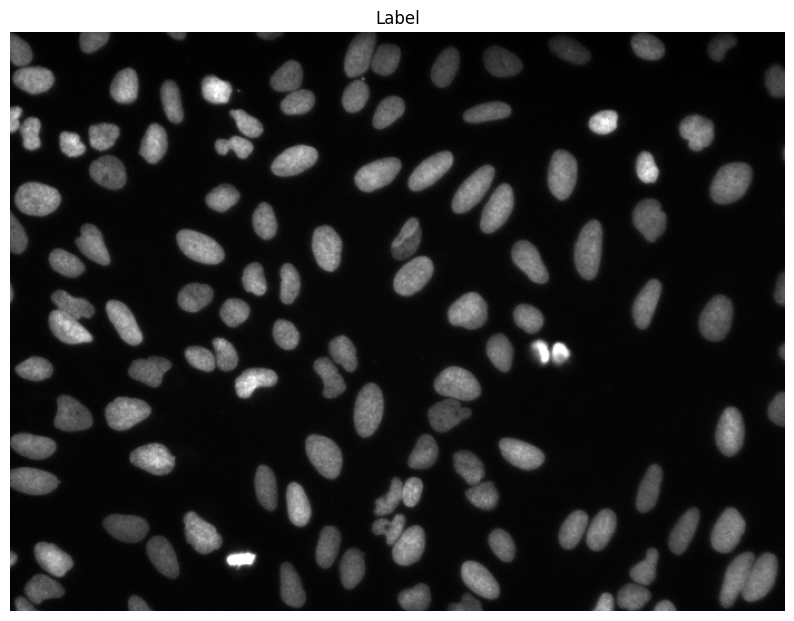

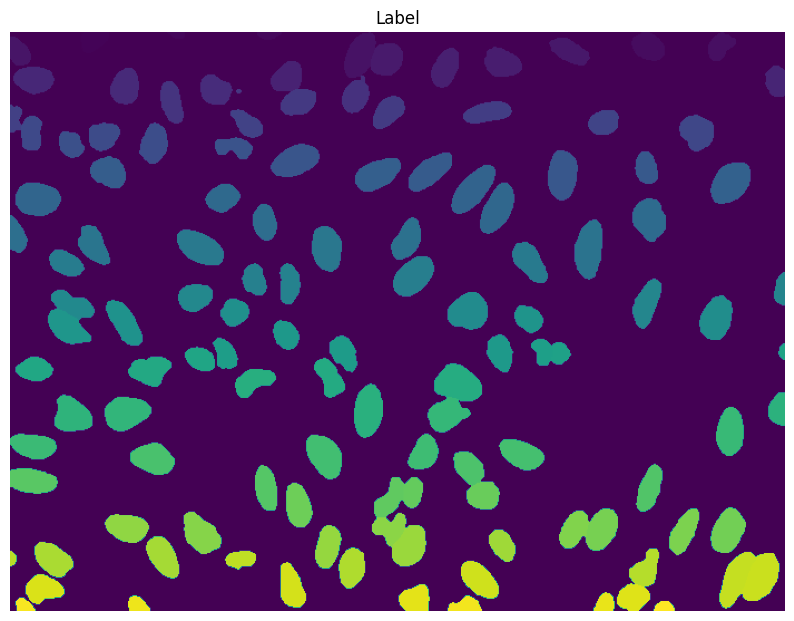

In [5]:
import matplotlib.pylab as plt
import numpy as np

for i, (images, mask, boxes, labels) in enumerate(valid_dataloader):
    print(images.shape)
    print(mask.shape)
    print(boxes.shape)
    print(labels)
    print(labels.shape)        

    plt.figure(figsize=(10, 10))
    plt.imshow(images.squeeze(0).detach().numpy().transpose(1, 2, 0))
    plt.title('Label')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.imshow(mask.detach().numpy().transpose(1, 2, 0))
    plt.title('Label')
    plt.axis('off')
    plt.show()
    break

In [13]:
 
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for i,(images, mask, boxes, labels) in enumerate(train_dataloader):
        
        images = images.squeeze(0).to(device)
        boxes = boxes.squeeze(0).to(device)
        labels = labels.squeeze(0).to(device)
        mask = mask.to(device)

        optimizer.zero_grad()

        labels = labels.to(torch.int64)


        #print(targets[2])
        targets = {'masks' : mask , 'boxes': boxes, 'labels': labels}

        if boxes.shape[0] >0 :
        # Zero the gradients

            # Forward pass
            outputs = model([images], [targets])

            # Compute the total loss
            loss_classifier = outputs['loss_classifier']
            loss_box_reg = outputs['loss_box_reg']
            loss_objectness = outputs['loss_objectness']
            loss_rpn_box_reg = outputs['loss_rpn_box_reg']
            total_loss = loss_classifier + loss_box_reg + loss_objectness + loss_rpn_box_reg

            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item()

train_loss = train_loss / len(train_dataloader)
print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), "model/faster_rcnn_model.pth")

Epoch 1/1, Training Loss: 0.7228


### Validation

In [12]:

best_valid_loss = float('inf')

for epoch in range(num_epochs):  
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation during validation
        for image, mask, boxes, labels in valid_dataloader:
            image = image.squeeze(0).to(device)
            mask = mask.squeeze(0).to(device)
            boxes = boxes.squeeze(0).to(device)  # Remove the batch dimension
            labels = labels.squeeze(0).to(device)  # Remove the batch dimension

            labels = labels.to(torch.int64)

            targets = {'masks': mask, 'boxes': boxes, 'labels': labels}
            if boxes.shape[0] > 0:
                outputsval = model([image], [targets])
                
                #print(outputsval)
                
                scores = outputsval[0]['scores']
                loss_value = torch.sum(scores)/len(scores)
                val_loss += loss_value.item()

    
    
    val_loss = val_loss / len(valid_dataloader)
    print(f'Validation Loss: {val_loss:.4f}')

    # Saving the best model checkpoint
    if val_loss < best_valid_loss:
        print(f'Valid loss improved from {best_valid_loss:.4f} to {val_loss:.4f}. Saving checkpoint: {"model/valid_faster_rcnn_model.pth"}')

        best_valid_loss = val_loss
        torch.save(model.state_dict(), "model/valid_faster_rcnn_model.pth")

Validation Loss: 0.8742
Valid loss improved from inf to 0.8742. Saving checkpoint: model/valid_faster_rcnn_model.pth
